In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [15]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, padding=2, stride=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(in_features=256*6*6, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        return x

In [17]:
# Parameters
batch_size = 128
num_epochs = 30
lr = 0.001

num_classes=2
model = AlexNet(num_classes)

if CUDA:
    model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [14]:
import json
import zipfile
import os

# kaggle api
api_token = {"username":"aaa","key":"kkk"}
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d chetankv/dogs-cats-images --force
 
!ls /kaggle

 88% 384M/435M [00:03<00:00, 104MB/s]
User cancelled operation
 dataset   dogs-cats-images.zip  'dog vs cat'


In [6]:
!unzip dogs-cats-images.zip

Archive:  dogs-cats-images.zip
replace dataset/test_set/cats/cat.4001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/test_set/cats/cat.4001.jpg  
replace dataset/test_set/cats/cat.4002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
pwd

'/kaggle'

In [18]:
# Transform
transform = transforms.Compose(
                [transforms.Resize(size=(227,227)),
                 transforms.CenterCrop(224),
                 transforms.RandomRotation(20),
                  transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),]
                )

# Data
train_dataset = datasets.ImageFolder(root='/kaggle/dataset/training_set', transform=transform)
valid_dataset = datasets.ImageFolder(root='/kaggle/dataset/test_set', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
len(valid_dataset)

2000

In [19]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    total_train = 0
    correct_train = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = model(data) 
        loss = criterion(output, target) 

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        total_train += len(target)
        correct_train += sum((predicted == target).float())
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Train Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(train_loader),
               correct_train / float((batch_idx + 1) * batch_size),
               train_loss / float((batch_idx + 1) * batch_size)))
            
    train_acc_ = 100 * (correct_train / float(total_train))
    train_loss_ = train_loss / total_train
                    
    return train_acc_, train_loss_

In [20]:
def validate(valid_loader, model, criterion, epoch): 
    model.eval()
    total_valid = 0
    correct_valid = 0
    valid_loss = 0
    
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target) 

        predicted = torch.max(output.data, 1)[1]
        total_valid += len(target)
        correct_valid += sum((predicted == target).float())
        valid_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Valid Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(valid_loader),
               correct_valid / float((batch_idx + 1) * batch_size),
               valid_loss / float((batch_idx + 1) * batch_size)))
            
    valid_acc_ = 100 * (correct_valid / float(total_valid))
    valid_loss_ = valid_loss / total_valid
                    
    return valid_acc_, valid_loss_

In [21]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader):
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(num_epochs):
        # training
        train_acc_, train_loss_ = train(train_loader, model, criterion, optimizer, epoch)
        total_train_loss.append(train_loss_)
        total_train_accuracy.append(train_acc_)

        # validation
        with torch.no_grad():
            valid_acc_, valid_loss_ = validate(valid_loader, model, criterion, epoch)
            total_valid_loss.append(valid_loss_)
            total_valid_accuracy.append(valid_acc_)

        print('==========================================================================')
        print("Epoch: {}/{}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch+1, num_epochs, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [22]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)

Train Epoch: 1/30 [iter： 1/63], acc： 0.492188, loss： 0.005417
Valid Epoch: 1/30 [iter： 1/16], acc： 0.093750, loss： 0.005461
Epoch: 1/30， Train acc： 49.975002， Train loss： 0.005488， Valid acc： 49.300003， Valid loss： 0.005546
Train Epoch: 2/30 [iter： 1/63], acc： 0.523438, loss： 0.005415
Valid Epoch: 2/30 [iter： 1/16], acc： 0.914062, loss： 0.004081
Epoch: 2/30， Train acc： 52.637501， Train loss： 0.005441， Valid acc： 51.000004， Valid loss： 0.005648
Train Epoch: 3/30 [iter： 1/63], acc： 0.507812, loss： 0.005452
Valid Epoch: 3/30 [iter： 1/16], acc： 0.195312, loss： 0.005480
Epoch: 3/30， Train acc： 50.925003， Train loss： 0.005480， Valid acc： 50.200005， Valid loss： 0.005543
Train Epoch: 4/30 [iter： 1/63], acc： 0.546875, loss： 0.005412
Valid Epoch: 4/30 [iter： 1/16], acc： 0.843750, loss： 0.005119
Epoch: 4/30， Train acc： 50.887501， Train loss： 0.005461， Valid acc： 53.350002， Valid loss： 0.005518
Train Epoch: 5/30 [iter： 1/63], acc： 0.539062, loss： 0.005410
Valid Epoch: 5/30 [iter： 1/16], acc： 0.960

In [23]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(num_epochs), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(num_epochs), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

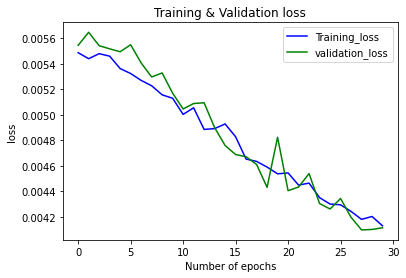

In [24]:
plot_result(total_train_loss, total_valid_loss, 'loss')

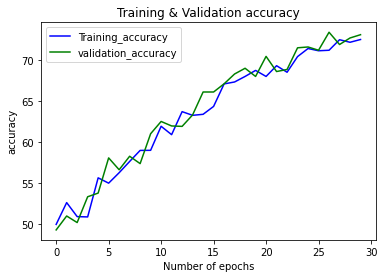

In [25]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')